In [35]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
from pathlib import Path
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models import GAT
from torch_geometric.nn.conv import GATv2Conv
from torch_geometric.data import Data
import pandas as pd
import networkx as nx

import networkx as nx
import pandas as pd
from node2vec import Node2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [4]:
# Load the Facebook Circles dataset and preprocess
def load_facebook_data():
    # Load edges
    edges = pd.read_csv('../data/facebook_combined.txt', delimiter=' ', header=None)
    edges = edges.values.T

    # Load labels (assuming binary classification for gender)
    gender_labels = []
    features = []
    for feat in Path("../data/facebook/").glob("*.featnames"):
        
        df = pd.read_csv(feat, sep=" ", index_col=0, header=None)
        gender_idx = df.index[df.iloc[:, 0].str.find("gender") != -1].values
        feature_names = (df[1] + df[2] + df[3].astype(str)).values

        # get label features
        df = pd.read_csv(feat.with_suffix(".feat"), sep=" ", index_col=0, header=None)
        tmp_df = pd.read_csv(feat.with_suffix(".egofeat"), sep=" ", header=None)
        tmp_df.columns = tmp_df.columns + 1
        tmp_df.index = [int(feat.stem)]
        df = pd.concat([tmp_df, df], axis=0)

        labels = df.iloc[:, gender_idx]
        gender_labels.append(labels.iloc[:, 0])
        print(f"для {feat}")
        stat_gender_collision = (labels.iloc[:, 0] != labels.iloc[:, 1]).sum() / labels.shape[0]
        print(f"количество правильных гендеров: {stat_gender_collision}")
        print()
        # иногда почему то гендер пересекается...

        df.columns = feature_names
        features.append(df)

    gender_labels = pd.concat(gender_labels, axis=0)
    gender_labels = gender_labels[~gender_labels.index.duplicated(keep="first")]
    features = pd.concat(features, axis=0)
    features = features[~features.index.duplicated(keep="first")]
    # Тут в фичах будет довольно много плохих фичей, поэтому их стоит дропнуть
    good_features = features.isna().sum() 
    good_features = good_features[(good_features / features.shape[0]) < 0.2].index
    features = features[good_features].fillna(0)

    gender_labels = torch.tensor(gender_labels.sort_index().values)
    features = torch.tensor(features.sort_index().values, dtype=torch.float32)
    edge_index = torch.tensor(edges, dtype=torch.long)

    return features, edge_index, gender_labels

### Define model

In [5]:
# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [6]:
# Define the GAT model
class GAT_model(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GAT_model, self).__init__()
        self.gat = GAT(in_channels, hidden_channels, 3, out_channels=out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        return F.log_softmax(self.gat(x, edge_index), dim=1)

## Test with random feature vectors for nodes

In [5]:
# Prepare the data
features, edge_index, labels = load_facebook_data()
# features can be random
random_features = torch.randn(labels.shape[0], 32)  # 16-dim node features

data = Data(x=random_features, edge_index=edge_index, y=labels)

# Split the data into train and test sets
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
train_mask[:int(0.8 * data.num_nodes)] = True
test_mask = ~train_mask

data.train_mask = train_mask
data.test_mask = test_mask


для ../data/facebook/686.featnames
количество правильных гендеров: 0.9532163742690059

для ../data/facebook/698.featnames
количество правильных гендеров: 0.9701492537313433

для ../data/facebook/1684.featnames
количество правильных гендеров: 0.9798234552332913

для ../data/facebook/348.featnames
количество правильных гендеров: 0.9868421052631579

для ../data/facebook/3437.featnames
количество правильных гендеров: 0.9598540145985401

для ../data/facebook/107.featnames
количество правильных гендеров: 0.988527724665392

для ../data/facebook/3980.featnames
количество правильных гендеров: 0.9666666666666667

для ../data/facebook/1912.featnames
количество правильных гендеров: 0.9880952380952381

для ../data/facebook/414.featnames
количество правильных гендеров: 0.9625

для ../data/facebook/0.featnames
количество правильных гендеров: 0.9827586206896551



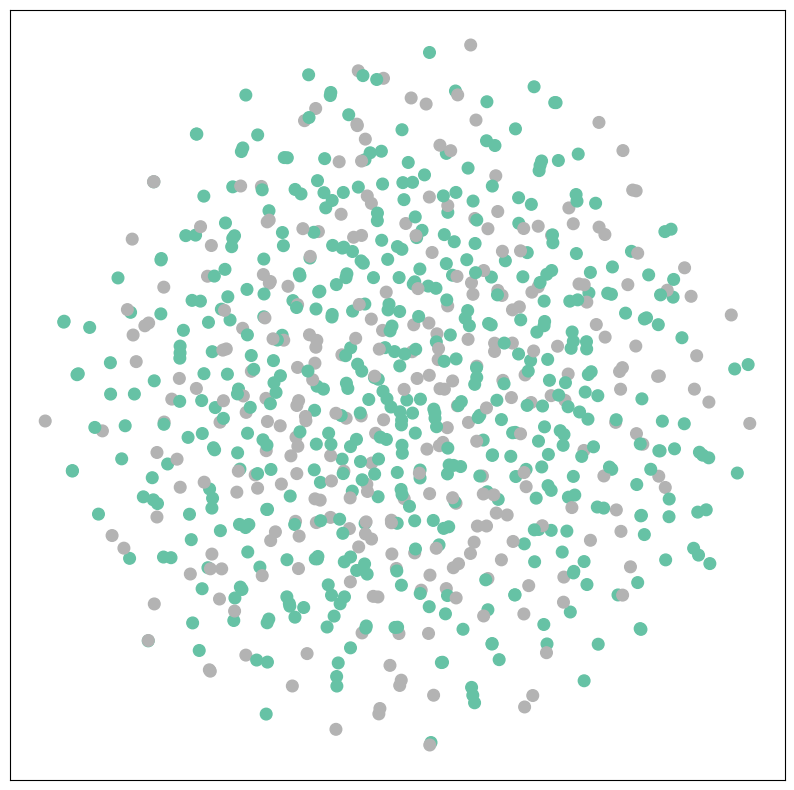

In [15]:
color = labels[data.test_mask]
visualize(data.x[data.test_mask], color)

### GCN MODEL

In [8]:
# Initialize the model, optimizer, and loss function
model = GCN(in_channels=32, hidden_channels=64, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        logits = model(data)
        test_mask = data.test_mask
        pred = logits[test_mask].max(1)[1]
        acc = pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
    return acc

# Train the model
for epoch in range(100):
    loss = train()
    acc = test()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')

print('Final Test Accuracy:', acc)

Epoch 0, Loss: 0.7559, Test Accuracy: 0.6287
Epoch 10, Loss: 0.6534, Test Accuracy: 0.6324
Epoch 20, Loss: 0.6408, Test Accuracy: 0.6324
Epoch 30, Loss: 0.6366, Test Accuracy: 0.6300
Epoch 40, Loss: 0.6299, Test Accuracy: 0.6250
Epoch 50, Loss: 0.6236, Test Accuracy: 0.6176
Epoch 60, Loss: 0.6226, Test Accuracy: 0.6200
Epoch 70, Loss: 0.6155, Test Accuracy: 0.6225
Epoch 80, Loss: 0.6104, Test Accuracy: 0.6250
Epoch 90, Loss: 0.6062, Test Accuracy: 0.6238
Final Test Accuracy: 0.6274752475247525


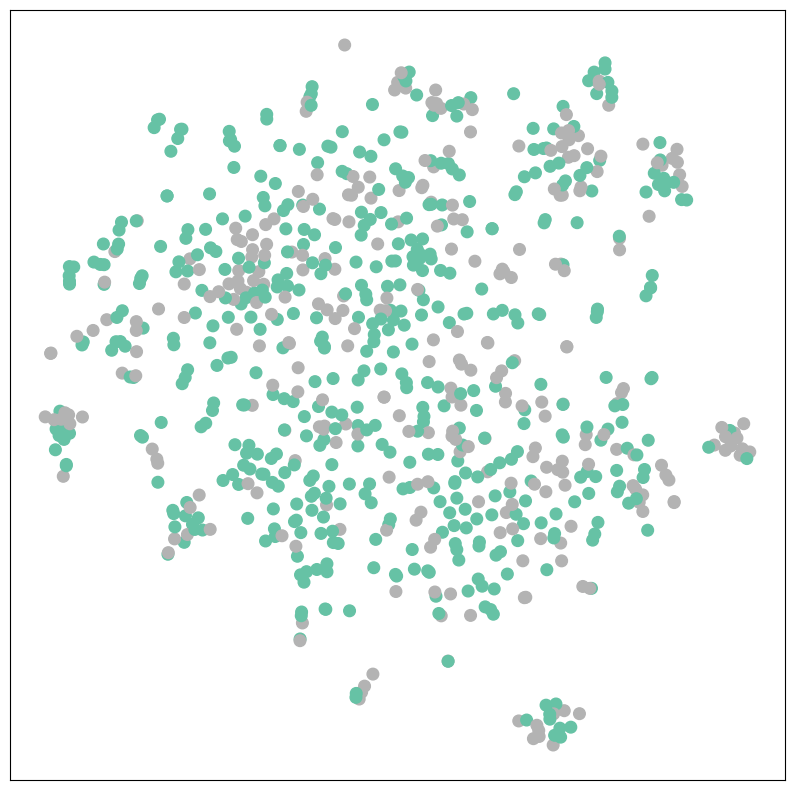

In [18]:
color = labels[data.test_mask]
embs = model.conv1(data.x, data.edge_index)[data.test_mask]
visualize(embs, color)

In [9]:
### GAT MODEL

# Initialize the model, optimizer, and loss function
model = GAT_model(in_channels=data.x.shape[1], hidden_channels=64, out_channels=2).to(device)
data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        logits = model(data)
        test_mask = data.test_mask
        pred = logits[test_mask].max(1)[1]
        acc = pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
    return acc

# Train the model
for epoch in range(200):
    loss = train()
    acc = test()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')

print('Final Test Accuracy:', acc)

Epoch 0, Loss: 0.6911, Test Accuracy: 0.6312
Epoch 10, Loss: 0.6479, Test Accuracy: 0.6312
Epoch 20, Loss: 0.6354, Test Accuracy: 0.6312
Epoch 30, Loss: 0.6243, Test Accuracy: 0.6361
Epoch 40, Loss: 0.6111, Test Accuracy: 0.6225
Epoch 50, Loss: 0.5996, Test Accuracy: 0.6114
Epoch 60, Loss: 0.5879, Test Accuracy: 0.6386
Epoch 70, Loss: 0.5730, Test Accuracy: 0.6436
Epoch 80, Loss: 0.5610, Test Accuracy: 0.6485
Epoch 90, Loss: 0.5428, Test Accuracy: 0.6498
Epoch 100, Loss: 0.5540, Test Accuracy: 0.6361
Epoch 110, Loss: 0.5352, Test Accuracy: 0.6238
Epoch 120, Loss: 0.5174, Test Accuracy: 0.6213
Epoch 130, Loss: 0.5025, Test Accuracy: 0.6312
Epoch 140, Loss: 0.5233, Test Accuracy: 0.6126
Epoch 150, Loss: 0.5012, Test Accuracy: 0.6101
Epoch 160, Loss: 0.4824, Test Accuracy: 0.6213
Epoch 170, Loss: 0.4900, Test Accuracy: 0.5829
Epoch 180, Loss: 0.4793, Test Accuracy: 0.6052
Epoch 190, Loss: 0.4608, Test Accuracy: 0.6089
Final Test Accuracy: 0.5903465346534653


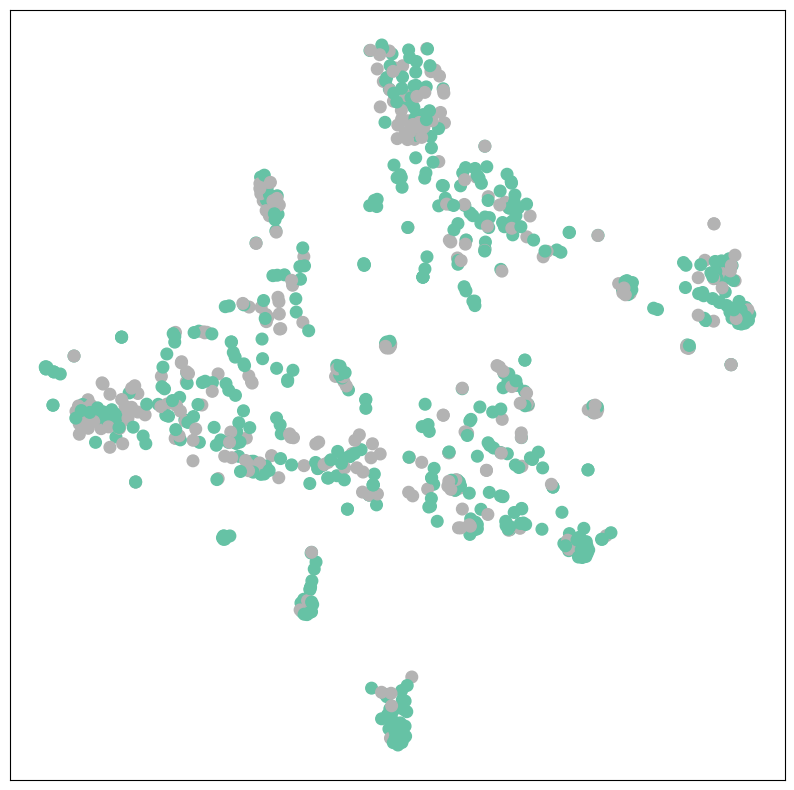

In [15]:
color = labels[data.test_mask.cpu()]
x, edge_index = data.x, data.edge_index
for idx, module in enumerate(model.gat.children()):
    if idx == 2:
        embs = module[0](x, edge_index)
        embs = module[1](embs, edge_index)
        break
embs = embs[data.test_mask]
visualize(embs, color)

### Now test with features, extracted from dataset

In [16]:
data.x=features
data.to(device)

# Initialize the model, optimizer, and loss function
model = GCN(in_channels=data.x.shape[1], hidden_channels=64, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        logits = model(data)
        test_mask = data.test_mask
        pred = logits[test_mask].max(1)[1]
        acc = pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
    return acc

# Train the model
for epoch in range(100):
    loss = train()
    acc = test()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')

print('Final Test Accuracy:', acc)

Epoch 0, Loss: 0.6856, Test Accuracy: 0.6312
Epoch 10, Loss: 0.6366, Test Accuracy: 0.6559
Epoch 20, Loss: 0.6206, Test Accuracy: 0.6559
Epoch 30, Loss: 0.6135, Test Accuracy: 0.6671
Epoch 40, Loss: 0.6131, Test Accuracy: 0.6646
Epoch 50, Loss: 0.6079, Test Accuracy: 0.6819
Epoch 60, Loss: 0.6030, Test Accuracy: 0.6745
Epoch 70, Loss: 0.5991, Test Accuracy: 0.6782
Epoch 80, Loss: 0.5978, Test Accuracy: 0.6708
Epoch 90, Loss: 0.5934, Test Accuracy: 0.6621
Final Test Accuracy: 0.6683168316831684


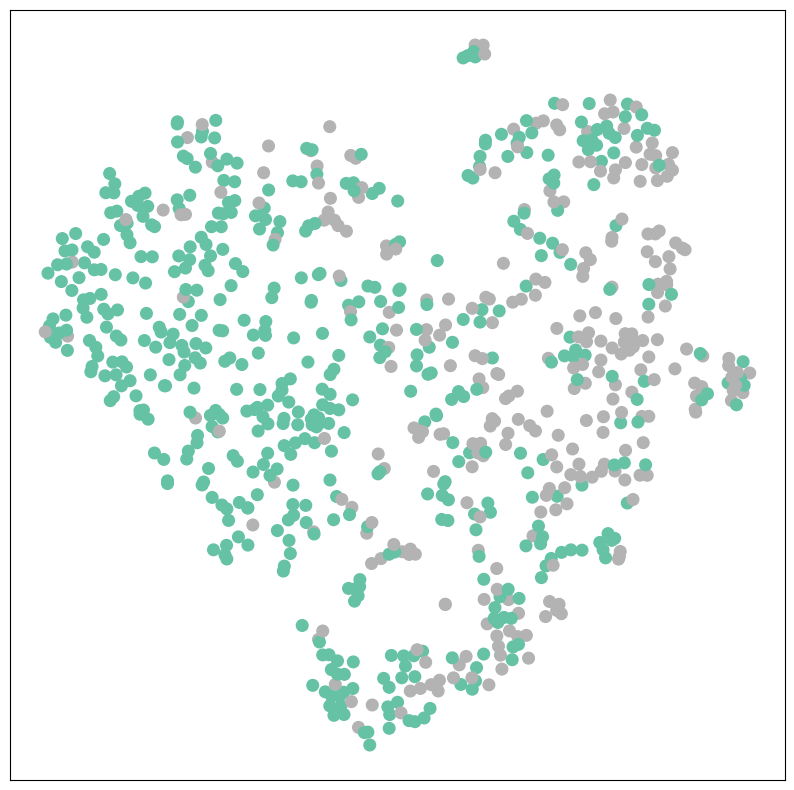

In [17]:
color = labels[data.test_mask.cpu()]
embs = model.conv1(data.x, data.edge_index)[data.test_mask]
visualize(embs, color)

### Test GAT model

In [18]:
# Initialize the model, optimizer, and loss function
model = GAT_model(in_channels=data.x.shape[1], hidden_channels=64, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        logits = model(data)
        test_mask = data.test_mask
        pred = logits[test_mask].max(1)[1]
        acc = pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
    return acc

# Train the model
for epoch in range(200):
    loss = train()
    acc = test()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')

print('Final Test Accuracy:', acc)

Epoch 0, Loss: 0.7058, Test Accuracy: 0.6312
Epoch 10, Loss: 0.6490, Test Accuracy: 0.6312
Epoch 20, Loss: 0.6352, Test Accuracy: 0.6312
Epoch 30, Loss: 0.6227, Test Accuracy: 0.6374
Epoch 40, Loss: 0.6103, Test Accuracy: 0.6448
Epoch 50, Loss: 0.5993, Test Accuracy: 0.6844
Epoch 60, Loss: 0.5900, Test Accuracy: 0.7178
Epoch 70, Loss: 0.3889, Test Accuracy: 0.8391
Epoch 80, Loss: 0.2088, Test Accuracy: 0.9208
Epoch 90, Loss: 0.1316, Test Accuracy: 0.9542
Epoch 100, Loss: 0.0929, Test Accuracy: 0.9542
Epoch 110, Loss: 0.0636, Test Accuracy: 0.9666
Epoch 120, Loss: 0.0431, Test Accuracy: 0.9493
Epoch 130, Loss: 0.0340, Test Accuracy: 0.9579
Epoch 140, Loss: 0.0289, Test Accuracy: 0.9579
Epoch 150, Loss: 0.0269, Test Accuracy: 0.9629
Epoch 160, Loss: 0.0256, Test Accuracy: 0.9678
Epoch 170, Loss: 0.0248, Test Accuracy: 0.9678
Epoch 180, Loss: 0.0242, Test Accuracy: 0.9691
Epoch 190, Loss: 0.0238, Test Accuracy: 0.9703
Final Test Accuracy: 0.9702970297029703


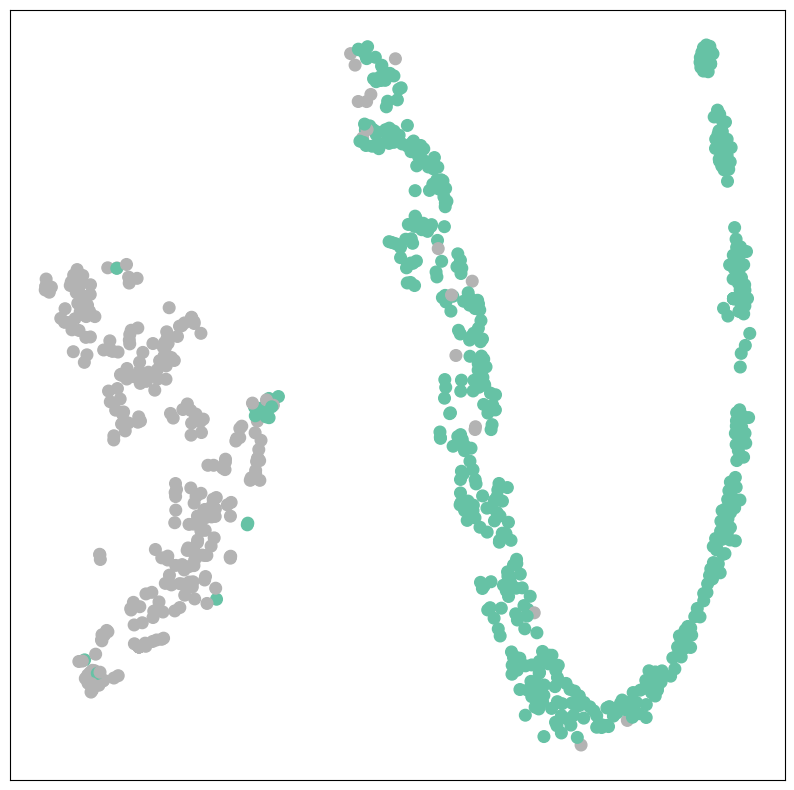

In [19]:
color = labels[data.test_mask.cpu()]
x, edge_index = data.x, data.edge_index
for idx, module in enumerate(model.gat.children()):
    if idx == 2:
        embs = module[0](x, edge_index)
        embs = module[1](embs, edge_index)
        break
embs = embs[data.test_mask]
visualize(embs, color)

## Craft features from node2vec

In [11]:
import pickle
if not Path("../data/n2v_embs.pcl").exists():
    # Prepare the graph
    G = nx.from_edgelist(data.edge_index.cpu().numpy().T)

    # Apply Node2Vec
    node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
    model_nv = node2vec.fit(window=10, min_count=1, batch_words=4)

    # Extract node embeddings
    node_embeddings = {node: model_nv.wv[node] for node in G.nodes()}

    n2v_embs = [node_embeddings[idx] for idx in range(4039)]
    with open("../data/n2v_embs.pcl", "wb") as f:
        pickle.dump(np.vstack(n2v_embs), f)
    n2v_embs = np.vstack(n2v_embs)
else:
    with open("../data/n2v_embs.pcl", "rb") as f:
        n2v_embs = pickle.load(f)

### GCN model

In [33]:
data.x=torch.tensor(np.vstack(n2v_embs), dtype=torch.float32)
data.to(device)

# Initialize the model, optimizer, and loss function
model = GCN(in_channels=data.x.shape[1], hidden_channels=64, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        logits = model(data)
        test_mask = data.test_mask
        pred = logits[test_mask].max(1)[1]
        acc = pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
    return acc

# Train the model
for epoch in range(100):
    loss = train()
    acc = test()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')

print('Final Test Accuracy:', acc)

Epoch 0, Loss: 0.7436, Test Accuracy: 0.6312
Epoch 10, Loss: 0.6844, Test Accuracy: 0.6312
Epoch 20, Loss: 0.6685, Test Accuracy: 0.6337
Epoch 30, Loss: 0.6583, Test Accuracy: 0.6337
Epoch 40, Loss: 0.6516, Test Accuracy: 0.6312
Epoch 50, Loss: 0.6480, Test Accuracy: 0.6324
Epoch 60, Loss: 0.6454, Test Accuracy: 0.6312
Epoch 70, Loss: 0.6419, Test Accuracy: 0.6287
Epoch 80, Loss: 0.6419, Test Accuracy: 0.6312
Epoch 90, Loss: 0.6385, Test Accuracy: 0.6262
Final Test Accuracy: 0.6324257425742574


In [34]:
# Initialize the model, optimizer, and loss function
model = GAT_model(in_channels=data.x.shape[1], hidden_channels=64, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        logits = model(data)
        test_mask = data.test_mask
        pred = logits[test_mask].max(1)[1]
        acc = pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
    return acc

# Train the model
for epoch in range(200):
    loss = train()
    acc = test()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')

print('Final Test Accuracy:', acc)

Epoch 0, Loss: 0.6928, Test Accuracy: 0.6312
Epoch 10, Loss: 0.6590, Test Accuracy: 0.6312
Epoch 20, Loss: 0.6516, Test Accuracy: 0.6312
Epoch 30, Loss: 0.6465, Test Accuracy: 0.6312
Epoch 40, Loss: 0.6402, Test Accuracy: 0.6101
Epoch 50, Loss: 0.6339, Test Accuracy: 0.5693
Epoch 60, Loss: 0.6277, Test Accuracy: 0.5730
Epoch 70, Loss: 0.6188, Test Accuracy: 0.5606
Epoch 80, Loss: 0.6123, Test Accuracy: 0.6027
Epoch 90, Loss: 0.6134, Test Accuracy: 0.6040
Epoch 100, Loss: 0.6377, Test Accuracy: 0.6040
Epoch 110, Loss: 0.6026, Test Accuracy: 0.6114
Epoch 120, Loss: 0.5886, Test Accuracy: 0.6114
Epoch 130, Loss: 0.5816, Test Accuracy: 0.6077
Epoch 140, Loss: 0.5796, Test Accuracy: 0.6077
Epoch 150, Loss: 0.5761, Test Accuracy: 0.6027
Epoch 160, Loss: 0.5698, Test Accuracy: 0.6101
Epoch 170, Loss: 0.5758, Test Accuracy: 0.6064
Epoch 180, Loss: 0.5652, Test Accuracy: 0.6126
Epoch 190, Loss: 0.5651, Test Accuracy: 0.6101
Final Test Accuracy: 0.6027227722772277


## Edge prediction task

In [30]:
# Define the GAT model
class GAT_edges(torch.nn.Module):
    def __init__(self, in_channels, out_channels, n_layers=3):
        super(GAT_edges, self).__init__()
        self.gat_list = torch.nn.ModuleList([
            GATv2Conv(in_channels, out_channels, dropout=0.6)] +
            [GATv2Conv(out_channels, out_channels, dropout=0.6)] * (n_layers - 1)
        )

        self.id = torch.nn.Identity()
        self.edge_classifier = torch.nn.ModuleList([
            torch.nn.Linear(out_channels * 2, out_channels * 2)] * 2 +
            [torch.nn.Linear(out_channels * 2, 2),
        ])

    @staticmethod
    def get_edges_embs(nodes_emb, edges_idx):
        node1 = torch.take_along_dim(nodes_emb, edges_idx[:, 0].view(-1, 1), dim=0)
        node2 = torch.take_along_dim(nodes_emb, edges_idx[:, 1].view(-1, 1), dim=0)
        return torch.concat([node1, node2], dim=1)

    def forward(self, x, edge_index, edges_predict):
        for encoder in self.gat_list:
            x = F.dropout(x, p=0.6, training=self.training)
            x = encoder(x, edge_index)
            x = F.elu(x)
        edges_embs = self.get_edges_embs(x, edges_predict)
        x = edges_embs
        for idx, edge_cls in enumerate(self.edge_classifier):
            x_id = self.id(x)
            x = edge_cls(x)
            if idx != len(self.edge_classifier) - 1:
                x = x + x_id
                x = F.relu(x)

        return x

### Construct dataset

In [6]:
data.x=features
data.to(device)

Data(x=[4039, 41], edge_index=[2, 88234], y=[4039], train_mask=[4039], test_mask=[4039])

In [7]:
edges = data.edge_index.cpu().numpy().T
while True:
    train_edges, test_edges = train_test_split(edges, train_size=0.8)
    G = nx.Graph()
    G.add_edges_from(train_edges)
    if nx.is_connected(G):
        break
    

In [8]:
def construct_negative_samples(size_, true_samples):
    samples = set(map(tuple, np.random.randint(0, 4039, size=(size_, 2))))
    samples = samples - true_samples
    return np.array(list(samples))

In [32]:
true_samples = set(map(tuple, edges))
# Initialize the model, optimizer, and loss function
model = GAT_edges(in_channels=data.x.shape[1], out_channels=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    negative = construct_negative_samples(len(edges), true_samples)
    x, edge_index = data.x, data.edge_index
    out = model(x, torch.tensor(train_edges).T.to(device), torch.tensor(np.vstack([train_edges, negative])).to(device))
    target = torch.concat(
        [
            torch.ones((len(train_edges),), dtype=torch.long),
            torch.zeros((len(negative),), dtype=torch.long),
        ]
    ).to(device)
    loss = F.cross_entropy(out, target)
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        negative = construct_negative_samples(len(edges), true_samples)
        x, edge_index = data.x, data.edge_index
        out = model(x, torch.tensor(train_edges).T.to(device), torch.tensor(np.vstack([test_edges, negative])).to(device))
        target = torch.concat(
            [
                torch.ones((len(test_edges),), dtype=torch.long),
                torch.zeros((len(negative),), dtype=torch.long),
            ]
        ).to(device)
        pred = out.max(1)[1]
        f1 = f1_score(target.cpu().numpy(), pred.cpu().numpy())
    return f1

# Train the model
for epoch in range(400):
    loss = train()
    acc = test()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test F1: {acc:.4f}')

print('Final Test Accuracy:', acc)

Epoch 0, Loss: 0.7060, Test F1: 0.0000
Epoch 10, Loss: 0.6190, Test F1: 0.2881
Epoch 20, Loss: 0.5901, Test F1: 0.2892
Epoch 30, Loss: 0.5412, Test F1: 0.3320
Epoch 40, Loss: 0.5249, Test F1: 0.3973
Epoch 50, Loss: 0.5157, Test F1: 0.4067
Epoch 60, Loss: 0.5110, Test F1: 0.4706
Epoch 70, Loss: 0.4881, Test F1: 0.3853
Epoch 80, Loss: 0.4862, Test F1: 0.4242
Epoch 90, Loss: 0.4584, Test F1: 0.4264
Epoch 100, Loss: 0.4429, Test F1: 0.5139
Epoch 110, Loss: 0.4274, Test F1: 0.5246
Epoch 120, Loss: 0.4021, Test F1: 0.6053
Epoch 130, Loss: 0.4016, Test F1: 0.5775
Epoch 140, Loss: 0.4237, Test F1: 0.5943
Epoch 150, Loss: 0.4020, Test F1: 0.6213
Epoch 160, Loss: 0.4002, Test F1: 0.6003
Epoch 170, Loss: 0.3996, Test F1: 0.6081
Epoch 180, Loss: 0.4238, Test F1: 0.6660
Epoch 190, Loss: 0.3988, Test F1: 0.6268
Epoch 200, Loss: 0.3568, Test F1: 0.6266
Epoch 210, Loss: 0.3813, Test F1: 0.6393
Epoch 220, Loss: 0.3715, Test F1: 0.6208
Epoch 230, Loss: 0.3759, Test F1: 0.6154
Epoch 240, Loss: 0.3445, Te

In [33]:
model.eval()
with torch.no_grad():
    negative = construct_negative_samples(len(edges), true_samples)
    x, edge_index = data.x, data.edge_index
    out = model(x, torch.tensor(train_edges).T.to(device), torch.tensor(np.vstack([test_edges, negative])).to(device))
    target = torch.concat(
        [
            torch.ones((len(test_edges),), dtype=torch.long),
            torch.zeros((len(negative),), dtype=torch.long),
        ]
    ).to(device)
    pred = out.max(1)[1]
    f1 = f1_score(target.cpu().numpy(), pred.cpu().numpy())

In [53]:
print("Roc-auc score of second model out")
roc_auc_score(target.cpu().numpy(), out[:, 1].cpu().numpy())

Roc-auc score of second model out


0.9626878293353034

In [52]:
print("Model in cross entropy scenario")
print(classification_report(target.cpu().numpy(), pred.cpu().numpy()))

Model in cross entropy scenario
              precision    recall  f1-score   support

           0       0.99      0.80      0.88     87512
           1       0.49      0.96      0.65     17647

    accuracy                           0.83    105159
   macro avg       0.74      0.88      0.77    105159
weighted avg       0.91      0.83      0.84    105159



Если использовать не два выхода сети, и выбирать между ними максимальный, 
А просто использовать второй выход сети, и задать threshold выбора класса в 1.3, 
Получается сильно увеличить метрики.


In [51]:
print("Model in LogLoss scenario")
print(classification_report(target.cpu().numpy(), (out[:, 1].cpu().numpy() > 1.3)))

Model in LogLoss scenario
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     87512
           1       0.75      0.82      0.78     17647

    accuracy                           0.92    105159
   macro avg       0.86      0.88      0.87    105159
weighted avg       0.93      0.92      0.93    105159



In [50]:
### Test random model

print("Random model")
print(classification_report(target.cpu().numpy(), np.random.randint(0, 2, target.shape)))

Random model
              precision    recall  f1-score   support

           0       0.83      0.50      0.62     87512
           1       0.17      0.51      0.25     17647

    accuracy                           0.50    105159
   macro avg       0.50      0.50      0.44    105159
weighted avg       0.72      0.50      0.56    105159

